# Заглянем глубже: обучение на базе многообразий
Чтобы справиться с проблемой *нелинейных* зависимостей в данных, можно обратиться к классу методов, под названием *обучение на базе многообразий* (manifold learning). Это класс оценивателей без учителя, нацеленных на описание наборов данных как низкоразмерных многообразий, вложенных в пространство большей размерности.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Обучение на базе многообразий: HELLO
Начнем с генерации двумерных данных, подходящих для описания многообразия

In [3]:
def make_hello(N=1000, rseed=42):
    # Создаем рисунок с текстом "HELLO"; сохраняем его в формате PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Открываем этот файл PNG и берем из него случайные точки
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

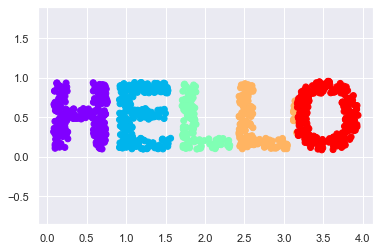

In [4]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

Входные данные двумерны и состоят из точек, формирующих слово HELLO. Эта внешняя форма данных поможет нам отслеживать визуально работу алгоритмов.
## Многомерное масштабирование (MDS)
Значения *х* и *у* не обязательно важны для внутренних зависимостей данных. Существенно в таком случае *расстояние* между каждой из точек и всеми остальными точками набора данных. Для представления его часто используют так называемую матрицу расстояний: при N точках создается такой массив размера NxN, что его элемент (*i,j*) содержит расстояние между точками *i* и *j*.

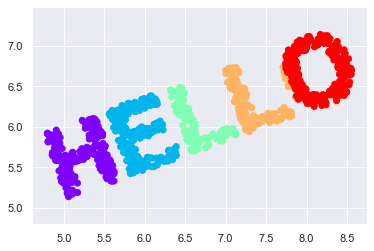

In [8]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

При использовании матрицы вращения для вращения данных *х* и *у* изменятся, но данные, по существу, останутся теми же

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

C:\Users\Георгий\AppData\Local\Temp\ipykernel_12684\321991705.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar();


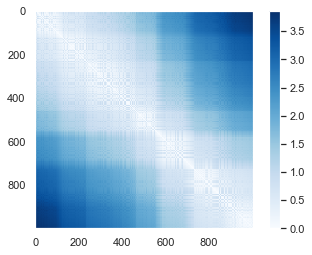

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

Сформировав аналогичным образом матрицу расстояний между подвергшимися вращению и сдвигу точками, увидим, что она не поменялась:

In [9]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

Благодаря подобной матрице расстояний мы получаем инвариантное к вращениям и сдвигам представление данных, но визуализация матрицы интуитивно не слишком ясна. Хотя вычисление матрицы расстояний на основе координат (*х,у*) не представляет труда, обратное преобразование расстояний в координаты *х* и *у* - непростая задача.

Именно для этого и служит алгоритм многомерного масштабирования: по заданной матрице расстояний между точками он восстанавливает D-мерное координатное представление данных. Посмотрим, как это будет выглядеть для нашей матрицы расстояний:

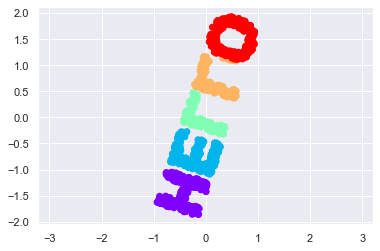

In [10]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

Алгоритм MDS восстанавливает одно из возможных двумерных координатных представлений данных на основе *одной лишь* матрицы расстояний размера NxN, описывающей зависимости между точками данных.
## MDS как обучение на базе многообразий
Полезность этого метода становится *очевиднее*, если учесть, что матрицы расстояний можно вычислить для данных *любой* размерности.Возведем наши данные в трехмерное пространство:

In [14]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

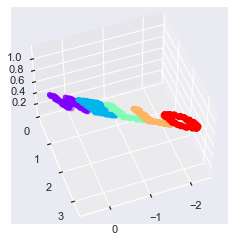

In [15]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

Теперь можно передать эти данные оценивателю MDS для вычисления матрицы расстояний и последующего определения оптимального двумерного вложения для нее.

***MDS-вложение трехмерных данных позволяет восстановить исходные данные с точностью до вращения и отражения.***

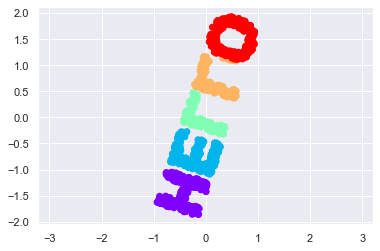

In [16]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

## Нелинейные вложения: там, где MDS не работает

In [17]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

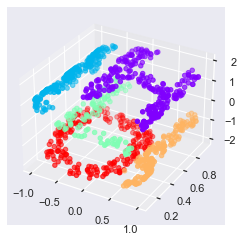

In [18]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

Если попытаться использовать для этих данных простой алгоритм MDS, он не сумеет "развернуть" это нелинейное вложение и мы потеряем из виду существенные зависимости во вложенном многообразии:

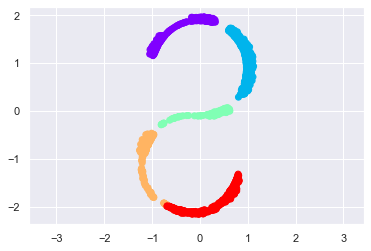

In [19]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

## Нелинейные многообразия: локально линейное вложение
Слева представлена модель, используемая в методе MDS: сохраняются расстояния между всеми парами точек в наборе данных. Справа - модель, используемая алгоритмом обучения на базе многообразий, который называется локально линейным вложением (LLE). Вместо сохранения всех расстояний сохраняются только расстояния между *соседними точками*: в данном случае ближайшими 100 соседями каждой точки.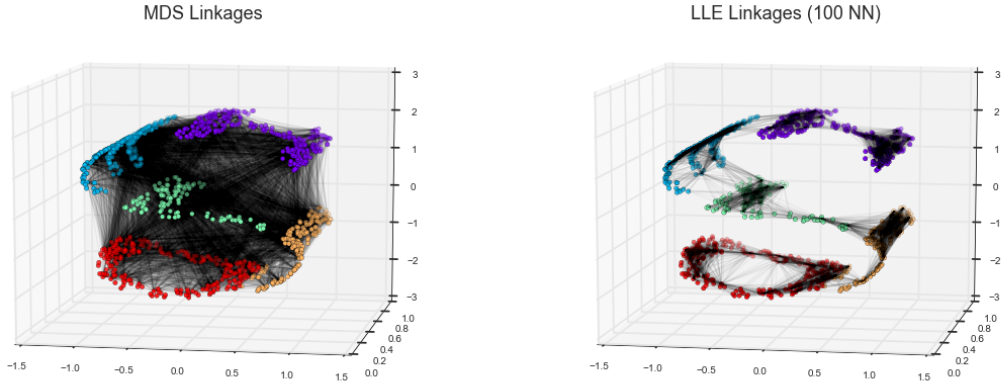

Именно это и делает метод LLE путем нахождения глобального экстремума отражающей эту логику функции стоимости.

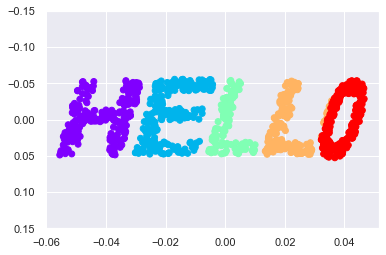

In [20]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

## Некоторые соображения относительно методов обучения на базе многообразий
На практике методы обучения на базе многообразий оказываются привередливыми, поэтому они редко используются для чего-то большего, чем простая качественная визуализация многомерных данных.
Причины, почему обучения на базе многообразий выглядит плохо по сравнению с методом РСА:

*Здесь и далее БМ - База Многообразий.

• При обучении на БМ не существует удачного фреймворка для обработки отсутствующих данных. В отличии от него в методе РСА существуют простые итеративные подходы для работы с отсутствующими данными.

• При обучении на БМ наличие шума в данных может "закоротить" многообразие и коренным образом изменить вложение. В отличие от него метод РСА естественным образом отделяет шум от наиболее важных компонент.

• Результат вложения многообразия обычно сильно зависит от количества выбранных соседей, и не существует надежного способа выбора оптимального числа соседей. В отличии от него метод РСА не требует подобного выбора.

• При обучении на БМ непросто определить оптимальное число измерений на выходе алгоритма. В отличие от него метод РСА позволяет определить выходную размерность, основываясь на объяснимой дисперсии.

• При обучении на БМ смысл вложенных измерений не всегда ясен. В методе РСА смысл главных компонент совершенно понятен.

• При обучении на БМ вычислительная сложность методов составляет *O[N^2]* или даже *O[N^3]*. Некоторые рандомизированные варианты метода РСА работают гораздо быстрее.

С учетом всего этого единственное безусловное преимущество методов обучения в базе многообразий перед РСА состоит в их способности сохранять нелинейные зависимости в данных. Именно поэтому стоит сначала изучать данные с помощью РСА, а затем использовать методы обучения на базе многообразий.

## Пример: использование Isomap для распознавания лиц
Обучение на базе многообразий часто применяется при исследовании зависимостей между многомерными точками данных. Один из распространенных случаев многомерных данных - изображения. Например, набор изображений, состоящих каждое из 1000 пикселов, можно рассматривать как набор точек в 1000-мерном пространстве - яркость каждого пиксела в каждом изображении соответствует координате в соответствующем измерении.

In [21]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

И так, у нас имеется 2370 изображении, каждое размером 2914 пикселов. Другими словами, изображения можно считать точками данных в 2914-мерном пространстве.

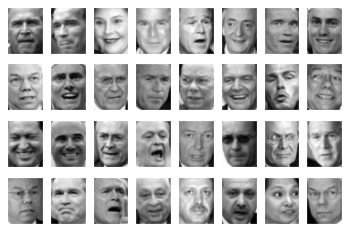

In [22]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Не помешает нарисовать низкоразмерное вложение 2914-мерных данных, чтобы ознакомиться с основными зависимостями между изображениями. Удобно также начать с вычисления РСА и изучения полученной доли объяснимой дисперсии. Это даст нам представление о том, сколько линейных признаков необходимо для описания этих данных:

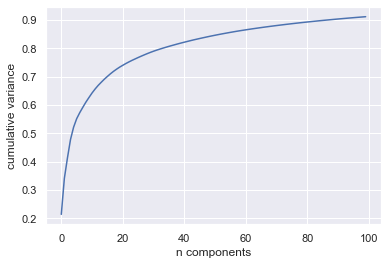

In [24]:
from sklearn.decomposition import PCA
model = PCA(100, svd_solver = 'randomized').fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

Как мы видим, для сохранения 90% дисперсии необходимо почти 100 компонентов. Это значит, что данные имеют высокую размерность и их невозможно описать линейно с помощью нескольких компонент.

In [25]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

Результат представляет собой двумерную проекцию всех исходных изображений. Чтобы было нагляднее - опишем функцию, выводящую миниатюры изображений в местах проекции:

In [26]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # Не отображаем слишком близко расположенные точки
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

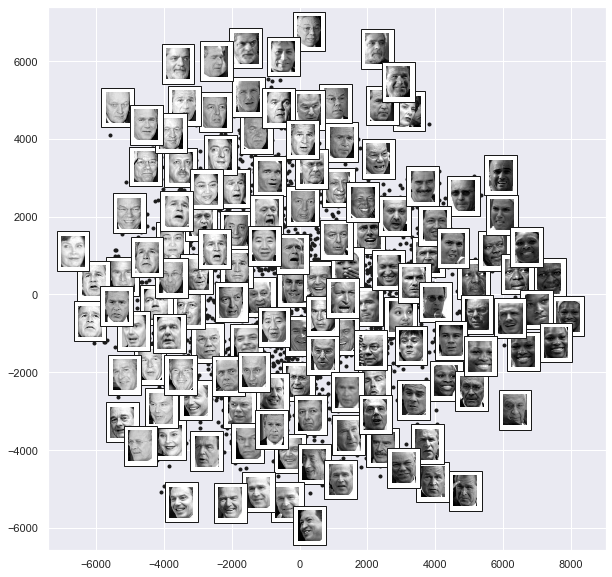

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

Далее можно перейти к классификации этих данных, возможно, с помощью признаков на базе многообразий в качестве входных данных для алгоритма классификации.